# Churn at Telco

# Goal:

- Find drivers for customer churn at Telco. Why are customers churning?
- Construct a ML classification model that accurately predicts customer churn.
- Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

# Imports

In [1]:
#standard DS imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

#sklearn imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, plot_confusion_matrix

#custom imports
import prepare
import acquire
import env

#filter out any noisy warning flags
import warnings
warnings.filterwarnings('ignore')

# Acquire

- Data acquired from the codeup telco_churn database
- It contained 7,043 rows and 21 columns before cleaning
- Each row represents a customer at telco
- Each column represents information about the customer


In [2]:
# Acquire Step
df = acquire.get_telco_data()

# Prepare

Prepare Actions:

- Dropped duplicate columns
- Dropped null values stored as whitespace, specifically from the total_charges column    
- Converted to correct datatype
- Converted binary categorical variables to numeric 
- Got dummies for non-binary categorical variables
- Concatenated dummy dataframe to original 
- split the data

In [3]:
# prepare and split the data
train, validate, test = prepare.prep_telco_data(df)

# drop object columns and create X_train of features only 
# and y_train of churn only. 
X_train = train.drop(columns=['churn_encoded', 'internet_service_type_Fiber optic', 'gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type', 'internet_service_type', 'payment_type'])
y_train = train.churn_encoded

X_validate = validate.drop(columns=['churn_encoded', 'internet_service_type_Fiber optic', 'gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type', 'internet_service_type', 'payment_type'])
y_validate = validate.churn_encoded

X_test = test.drop(columns=['churn_encoded', 'internet_service_type_Fiber optic', 'gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type', 'internet_service_type', 'payment_type'])
y_test = test.churn_encoded

# check the shape
X_train.shape, X_validate.shape, X_test.shape

((3937, 29), (1688, 29), (1407, 29))

# Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Churn| True or False, Has the customer left the company|
|Gender| Female or Male|
|Senior Citizen| Is the customer a senior citizen, yes or no|
|Partner| Does the customer have a partner designated upon signing a contract, yes or no|
|Dependents| Are there any dependents on file for the customer, yes or no|
|Tenure| How long, in weeks, have the customer been with Telco|
|Phone Service| Does the customer have phone service, yes or no|
|Multiple Lines| Does the customer have multiple lines of service, yes or no|
|Online Security| Does the customer have online security, yes, no, or no internet|
|Online Backup| Does the customer have backup for their internet, yes, no or no internet|
|Device Protection|Does the customer have device protection, yes, no, or no internet|
|Streaming Movies|Does the customer have the ability to stream movies, yes or no|
|Streaming TV|Does the customer have the ability to stream TV, yes or no|
|Contract Type|Does the customer have a one year, two year, or month to month contract|
|Internet Service Type|What type of internet service does the customer have, fiber optic, DSL, or no internet|
|Payment Type|How does the customer pay their bill, credit card, electronic check, or mailed check|

## A brief look at the data

In [4]:
# Looking at the cleaned up columns
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,0,0,0,1,0,0,0,1,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,0,0,0,1,0,1,0,1,0,0
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,1,0
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,0,1
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1


## A summary of the data

In [5]:
# Summary of the data
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
count,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,...,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000
mean,0.161290,32.775210,64.805131,2316.775641,0.498095,0.485141,0.302769,0.905258,0.590297,0.265685,...,0.386335,0.220218,0.391415,0.207010,0.243078,0.437389,0.220218,0.227330,0.327407,0.226314
std,0.367845,24.709604,30.294804,2284.984394,0.500060,0.499843,0.459514,0.292896,0.491841,0.441753,...,0.486971,0.414447,0.488129,0.405215,0.428997,0.496127,0.414447,0.419161,0.469327,0.418498
min,0.000000,1.000000,18.250000,18.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,34.700000,396.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,30.000000,70.250000,1414.800000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,56.000000,90.300000,3893.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.650000,8594.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Explore

## 1) Are customers with Fiber Optic more or less likely to churn?

Text(0.5, 1.0, 'Customers with fiber optic are more likely to churn')

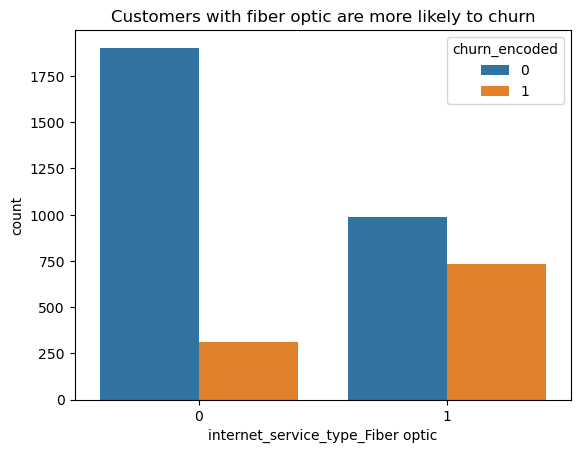

In [6]:
# Visualization for fiber optic
sns.countplot(data=train, x="internet_service_type_Fiber optic", hue="churn_encoded")
plt.title('Customers with fiber optic are more likely to churn')

- About 43% of customers with fiber optic churned 
- About 13% of customers without fiber optic churned

H_0: Customers with fiber optic are less likely to churn.  

H_a: Customers with fiber optic are more likely to churn.  

In [7]:
# Running a chi squared statistical test to compare proportions and have more confidence
alpha = 0.05
null_hypothesis = "Customers with fiber optic are less likely to churn."
alternative_hypothesis = "Customers with fiber optic are more likely to churn."

# Setup a crosstab of observed churn to fiber optic
observed = pd.crosstab(train.churn_encoded, train['internet_service_type_Fiber optic'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

# Create an if statement to test for the null hypothesis
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that Customers with fiber optic are less likely to churn.
Sufficient evidence to move forward understanding that Customers with fiber optic are more likely to churn.


2.831419548361709e-90

***Takeaway:***

It is more likely that customers who have fiber optic churned versus customers who did not have fiber optic.

## 2) Does the type of contract (one year, two year, or month to month) affect if a customer churns?¶

Text(0.5, 1.0, 'Month to month contracts have the highest level of churn')

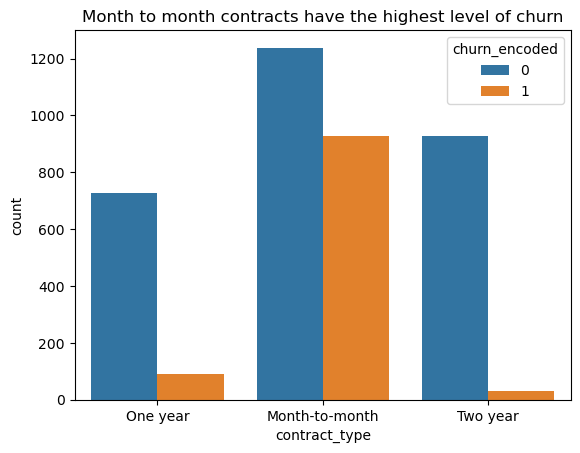

In [8]:
# Visualization to show level of churn in customer contracts.
sns.countplot(data=train, x="contract_type", hue="churn_encoded")
plt.title('Month to month contracts have the highest level of churn')

- Month to month contracts have the highest level of churn.
- One year contracts are the next highest, but still relatively low churn.
- Two year contracts have the lowest level of churn.

H_0: There is no correlation between type of contract and if a customer churns.  

H_a: There is a correlation between type of contract and if a customer churns.  

In [9]:
# Need to create a varialbe that holds month to month contracts for 
# train, validate, and test

monthly_train = (train['contract_type_One year'] == 0) & (train['contract_type_Two year'] == 0)
monthly_validate = (validate['contract_type_One year'] == 0) & (validate['contract_type_Two year'] == 0)
monthly_test = (test['contract_type_One year'] == 0) & (test['contract_type_Two year'] == 0)


In [10]:
# Create a new column for month to month contracts for the train, validate, and test df

train = train.assign(monthly_contract = monthly_train)
train['monthly_encoded'] = train.monthly_contract.map({True: 1, False: 0})

validate = validate.assign(monthly_contract = monthly_validate)
validate['monthly_encoded'] = validate.monthly_contract.map({True: 1, False: 0})

test = test.assign(monthly_contract = monthly_test)
test['monthly_encoded'] = test.monthly_contract.map({True: 1, False: 0})

In [11]:
# Running a chi squared statistical test to compare proportions and have more confidence
null_hypothesis = "There is no correlation between type of contract and if a customer churns"
alternative_hypothesis = "There is a correlation between type of contract and if a customer churns."

# Setup a crosstab of observed churn to month to month contracts
observed = pd.crosstab(train.churn_encoded, monthly_train)

chi2, p, degf, expected = stats.chi2_contingency(observed)

# Create an if statement to test for the null hypothesis
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that There is no correlation between type of contract and if a customer churns
Sufficient evidence to move forward understanding that There is a correlation between type of contract and if a customer churns.


3.4484593947893894e-143

***Takeaway:***

While it is no surprise that month to month contracts produce the highest level of churn, the drastic drop from month to month to one year and two year contracts should be looked at and possible incentives or discounts for the one year and two year contracts could reduce the amount of month to month contracts and level of churn.

## 3) Is there a service that is associated with more churn than expected?

Text(0.5, 1.0, 'Customers without online security have the highest level of churn')

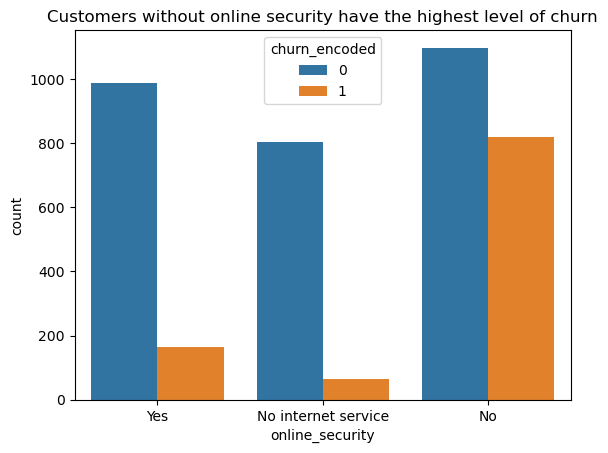

In [12]:
# Visualization to show level of churn for customers with and without online security
sns.countplot(data=train, x="online_security", hue="churn_encoded")
plt.title('Customers without online security have the highest level of churn')

- Customers with online security have 17% churn rate.
- Customers with no internet service have an 11% churn rate.
- Customers withouth online security have a 40% churn rate.

H_0: Customers with online security are less likely to churn.  
H_a: Customers without online security are more likely to churn.  

In [13]:
# Running a chi squared statistical test to compare proportions and have more confidence
alpha = 0.05
null_hypothesis = "Customers with online security are less likely to churn."
alternative_hypothesis = "Customers without online security are more likely to churn."

# Setup a crosstab of observed churn to online security
observed = pd.crosstab(train.churn_encoded, train.online_security)

chi2, p, degf, expected = stats.chi2_contingency(observed)

# Create an if statement to test for the null hypothesis
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that Customers with online security are less likely to churn.
Sufficient evidence to move forward understanding that Customers without online security are more likely to churn.


1.3862996282206897e-111

Text(0.5, 1.0, 'Churn for TV streaming exists but is not significant enough to use')

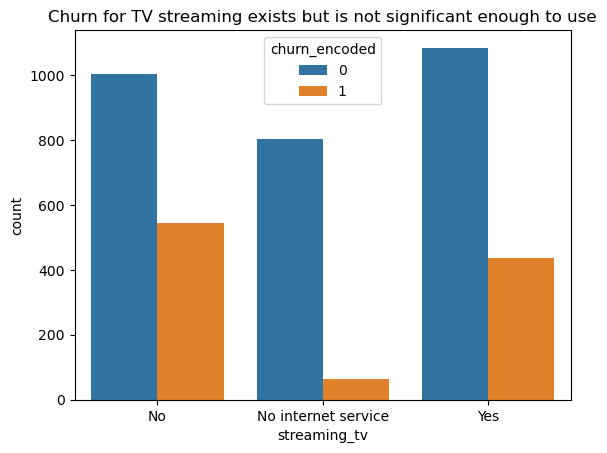

In [14]:
# Visualization to show level of churn for customers with and without streaming TV service
sns.countplot(data=train, x="streaming_tv", hue="churn_encoded")
plt.title('Churn for TV streaming exists but is not significant enough to use')

- Visualization to compare internet security to entertainment services. While there is churn, the difference between customers with and without tv streaming and the level of churn is not significant.

***Takeaways:***
    
The major contributor for customer churn is more correlated with internet services that provide security such as tech support, device protection, online backup, and online security.  

Other services for entertainment purposes such as streaming tv and movies had less of an impact on customer churn.

I have selected online security because this factor has the highest level of churn out of the other contributors noted above.

## 4) Do customers who churn have a higher average monthly spend than those who don't?¶

<AxesSubplot:title={'center':'Customers who spend between 70-100 dollars have the highest churn rate'}, xlabel='monthly_charges', ylabel='Count'>

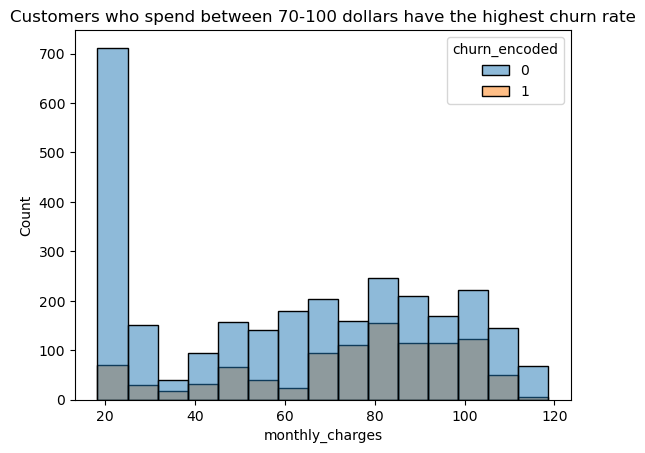

In [15]:
# Visualization to show level of churn for monthly charges
plt.title('Customers who spend between 70-100 dollars have the highest churn rate')
sns.histplot(data=train, x="monthly_charges", hue="churn_encoded")

- As charges increase, churn increases until the rate reaches over 100 dollars.
- The largest proportion of customers spent between 20-30 dollars.

H_0: There is no correlation between monthly charges and churn.  
H_a: There is a correlation between monthly charges and churn.  

In [16]:
# Need to create a varialbe that holds monthly charges greater than or equal 
# to 80 dollars for train, validate, and test

monthly_charges_80_train = (train['monthly_charges'] >= 80) 
monthly_charges_80_validate = (validate['monthly_charges'] >= 80) 
monthly_charges_80_test = (test['monthly_charges'] >= 80) 


In [17]:
# create a new column for monthly charges greater than 80 dollars 
# for the train, validate, and test df

train = train.assign(monthly_charges = monthly_charges_80_train)
train

train['monthly_charges_greater_than_80'] = train.monthly_charges.map({True: 1, False: 0})
train.head()

validate = validate.assign(monthly_charges = monthly_charges_80_validate)
validate['monthly_charges_greater_than_80'] = validate.monthly_charges.map({True: 1, False: 0})

test = test.assign(monthly_charges = monthly_charges_80_test)
test['monthly_charges_greater_than_80'] = test.monthly_charges.map({True: 1, False: 0})

In [18]:
# Running a chi squared statistical test to compare proportions and have more confidence
alpha = 0.05
null_hypothesis = "There is no correlation between monthly charges and churn."
alternative_hypothesis = "There is a correlation between monthly charges and churn."

# Setup a crosstab of observed churn to monthly charges
observed = pd.crosstab(train.churn_encoded, train.monthly_charges)

chi2, p, degf, expected = stats.chi2_contingency(observed)

# Create an if statement to test for the null hypothesis
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that There is no correlation between monthly charges and churn.
Sufficient evidence to move forward understanding that There is a correlation between monthly charges and churn.


1.282665827622829e-17

Text(0.5, 1.0, 'Customers who paid under $2000 churned the most')

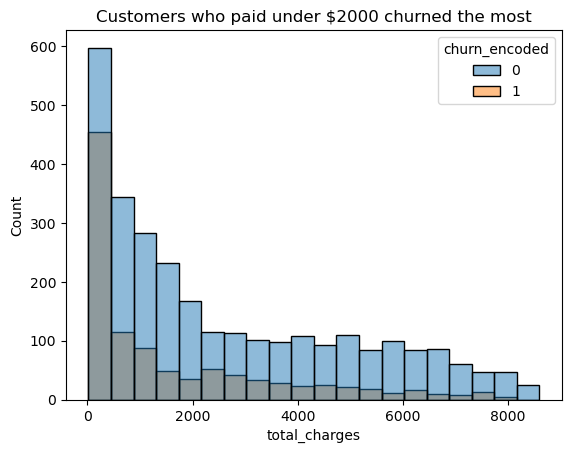

In [19]:
# Visualization to show level of churn for total charges
sns.histplot(data=train, x="total_charges", hue="churn_encoded")
plt.title('Customers who paid under $2000 churned the most')

- A large portion of the churn for total charges occurs at the lowest pay scale. Therefore, the correlation between total charges and churn is not significant enough to move forward.

***Takeaways:***
    
It would appear that the more money that was spent by the customer for monthly charges, the more likely they are to churn.

The large majority of those that churned spent $500 or less on total charges.

Those customers who spent about $80 a month were the most likely to churn.

Total charges produced an insufficient correlation between total charges and churn.

# Exploration Summary

- It is more likely that customers who have fiber optic churned versus customers who did not have fiber optic.
- Month to month contracts produce the highest level of churn, the drastic drop from month to month to one year and two year contracts should be looked at. 
- The major contributor for customer churn is more correlated with internet services that provide security such as tech support, device protection, online backup, and online security.
    - Other services for entertainment purposes such as streaming tv and movies had less of an impact on customer churn.
    - I have selected online security because this factor has the highest level of churn out of the other contributors noted above.
- It would appear that the more money that was spent by the customer, the more likely they are to churn.
    - Those customers who spent about $80 a month were the most likely to churn.

# Features I am moving to modeling With

- "internet_service_type_Fiber optic" (moderate difference in churn percentage, and relationship to churn is high)
- "month_to_month" (largest difference in churn percentage, and relationship to churn is the highest)
- "online_security" (moderate difference in churn percentage, and dependance is statistically significant)
- "monthly_charges" (moderate difference in rating observed, and difference is statistically significant)


# Features I'm not moving to modeling with

- TV and movie streaming services (minimal amount of churn associated with these services)
- "total charges" (There is no evidence that "total charges" is a driver of churn)

# Modeling

- I will use accuracy as my evaluation metric.
- Customers who did not churn makeup 73% of the data.
- By guessing not churned for every customer one could achieve an accuracy of 73% * 73% will be the baseline accuracy I use for this project
- I will be evaluating models developed using four different model types and various hyperparameter configurations 
- Models will be evaluated on train and validate data 
- The model that performs the best will then be evaluated on test data. 
- The decision tree model with max depth of 3 produced the best results.

In [20]:
# Create a variable that holds only the desired columns
testing_churn = ['online_security_Yes', 'internet_service_type_Fiber optic', 'monthly_encoded', 'monthly_charges_greater_than_80']

In [21]:
# drop all columns except for the target inputs: fiber optic, month to month contracts, 
# online security, and monthly charges.
# drop object columns and create X_train of features only 
# and y_train of churn only. 
X_train = train[testing_churn]
y_train = train.churn_encoded

X_validate = validate[testing_churn]
y_validate = validate.churn_encoded

X_test = test[testing_churn]
y_test = test.churn_encoded

# check the shape
X_train.shape, X_validate.shape, X_test.shape

((3937, 4), (1688, 4), (1407, 4))

In [32]:
# Start with the baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between 
# the baseline prediction and reality
matches_baseline_prediction = (y_train == 0)

# Printing the baseline accuracy
baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {baseline_accuracy}")

Baseline accuracy: 0.7343154686309372


# Decision Tree

In [23]:
#create the model with desired depth
churn_tree1 = DecisionTreeClassifier(max_depth=3, random_state=123)


#fit the model to train data
churn_tree1 = churn_tree1.fit(X_train, y_train)



# Evaluate the model's performance on train first, than validate
y_predictions = churn_tree1.predict(X_train)
y_predictions2 = churn_tree1.predict(X_validate)



# Use the model and print the accuracy for train and validate
accuracy = churn_tree1.score(X_train, y_train)
accuracy2 = churn_tree1.score(X_validate, y_validate)
print(f'Accuracy of Decision Tree on train data is: {accuracy}')
print(f'Accuracy of Decision Tree on validate data is: {accuracy2}')

Accuracy of Decision Tree on train data is: 0.7846075692151384
Accuracy of Decision Tree on validate data is: 0.7553317535545023


- Decision tree accuracy is better than the baseline accuracy.

# Logistic Regression

In [24]:
# create algorithm object
logit1 = LogisticRegression(C=1, 
                           random_state=123, 
                           intercept_scaling=1, 
                           solver='liblinear'
                          )

# fit model 
logit1.fit(X_train[['online_security_Yes', 'monthly_encoded']], y_train)

# Evaluate the model's performance on train first, than validate
y_predictions3 = logit1.predict(X_train[['online_security_Yes', 'monthly_encoded']])
y_preditions4 = logit1.predict(X_validate[['online_security_Yes', 'monthly_encoded']])

# Use the model and compute the accuracy
train_accuracy = logit1.score(X_train[['online_security_Yes', 'monthly_encoded']], 
                             y_train)
train_accuracy2 = logit1.score(X_validate[['online_security_Yes', 'monthly_encoded']], 
                             y_validate)

# Print the accuracies for train and validate
print(f'Accuracy of Logisitc Regression on train data is: {train_accuracy}')
print(f'Accuracy of Logisitc Regression on validate data is: {train_accuracy2}')

Accuracy of Logisitc Regression on train data is: 0.7343154686309372
Accuracy of Logisitc Regression on validate data is: 0.7340047393364929


- Logistic Regression accuracy is similar to the baseline accuracy.

# Random Forrest

In [25]:
# Create the model with required depth
seed = 42
rf = RandomForestClassifier(max_depth=5, random_state=42, min_samples_leaf=1)


In [26]:
# fit the data to train
rf.fit(X_train, y_train)

# Evaluate the model's performance on train first, than validate
y_pred = rf.predict(X_train)
y_pred = rf.predict(X_validate)

#Use the model, compute for accuracy, and print the accuracy of train and validate
accuracy5 = rf.score(X_train, y_train)
accuracy6 = rf.score(X_validate, y_validate)
print(f'Accuracy of Random Tree on train data is: {accuracy5}')
print(f'Accuracy of Random Tree on validate data is: {accuracy6}')

Accuracy of Random Tree on train data is: 0.7848615697231395
Accuracy of Random Tree on validate data is: 0.7523696682464455


- Random tree accuracy is better than the baseline accuracy.

# Comparing Models

- Decision Tree and Random Forest models performed better than the baseline on train and validate
- The Logisitc Regression model performed similar on the train and validate data to the baseline.
- Because the results of the Decision Tree and Random Forest models were very similar I could proceed to test with any of these models.
- I have chosen to move forward with the Decision Tree model because it performed slightly better on the validate data.

# Decision Tree on Test

In [27]:
# Evaluate the model's performance on test data
y_predictions_test = churn_tree1.predict(X_test)

#Use the model, compute the accuracy, and print the accuracy for test
accuracy_test = churn_tree1.score(X_test, y_test)
print(f'Accuracy of Decision Tree on test data is: {accuracy_test}')

Accuracy of Decision Tree on test data is: 0.7725657427149965


## Modeling Summary

- Decision Tree and Random Forest models performed better than the baseline on train and validate.
- The Logisitc Regression model performed similar on the train and validate data to the baseline.
- A Decision Tree model selected as the final model and had an accuracy of about 77% which is better than the baseline accuracy.

# Conclusions

## Exploration

- About 43% of customers with fiber optic churned.
- About 13% of customers without fiber optic churned.
- It is more likely that customers who have fiber optic churned versus customers who did not have fiber optic.
- Month to month contracts have the highest level of churn.
- One year contracts are the next highest, but still relatively low churn.
- Two year contracts have the lowest level of churn.
- While it is no surprise that month to month contracts produce the highest level of churn, the drastic drop from month to month to one year and two year contracts should be looked at and possible incentives or discounts for the one year and two year contracts could reduce the amount of month to month contracts and level of churn.
- Customers with online security have 17% churn rate.
- Customers with no internet service have an 11% churn rate.
- Customers withouth online security have a 40% churn rate.
- The major contributor for customer churn is more correlated with internet services that provide security such as tech support, device protection, online backup, and online security.
- Other services for entertainment purposes such as streaming tv and movies had less of an impact on customer churn.
- As charges increase, churn increases until the rate reaches over 100 dollars.
- The largest proportion of customers spent between 20-30 dollars.
- It would appear that the more money that was spent by the customer, the more likely they are to churn.
- The large majority of those that churned spent 500 dollars or less on total charges.
- Those customers who spent about 80 dollars a month were the most likely to churn.
- Total charges produced insufficient data to support a correlation between total charges and churn.

# Modeling

***The final model outperformed the baseline. Possible reasons include:***

- Choosing targeted areas like online security and month to month contracts included more churned customers than those that did not churn.
- The targeted contributors were reduced to only four and the inclusion of additional contributors might bring down the performance of the model.


# Recommendations

- To reduce churn decrease the amount of month to month contracts and increase the amount of one and two year contracts.
- Provide online security to all of the customers, this area produced the highest probability of customer churn.

# Next Steps

- Explore billing methods and see if this has an effect on customer churn.
- Investigate customers' personal information such as gender, dependents status, and if the customer had a partner to determine if these factors contributed to multiple lines, monthly charges, or type of contracts purchased.